# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import GRU
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.optimizers import SGD, Adam

# Reading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data sets/Time-Series Analysis Dataset.csv',index_col='datetime_local',parse_dates=True)
df.index.freq='MS'

# Visualizing the data

In [ ]:
df.head()

,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,icon
datetime_local,,,,,,,,,,,
01-10-2019 00:00,26.0,1.0,22.01,101.0,3.08,6.42,1008.45,0.0,268.6,0.0,partly-cloudy-night
01-10-2019 01:00,25.0,1.0,22.06,105.0,2.94,6.28,1008.24,0.0,269.1,0.0,partly-cloudy-night
01-10-2019 02:00,25.0,1.0,22.06,106.0,2.82,6.08,1007.90,0.0,269.7,0.0,partly-cloudy-night
01-10-2019 03:00,24.0,1.0,21.87,106.0,2.63,5.74,1007.61,0.0,270.4,0.0,partly-cloudy-night
01-10-2019 04:00,23.0,1.0,21.53,100.0,2.39,5.30,1007.51,0.0,271.3,0.0,partly-cloudy-night


<Axes: xlabel='datetime_local'>

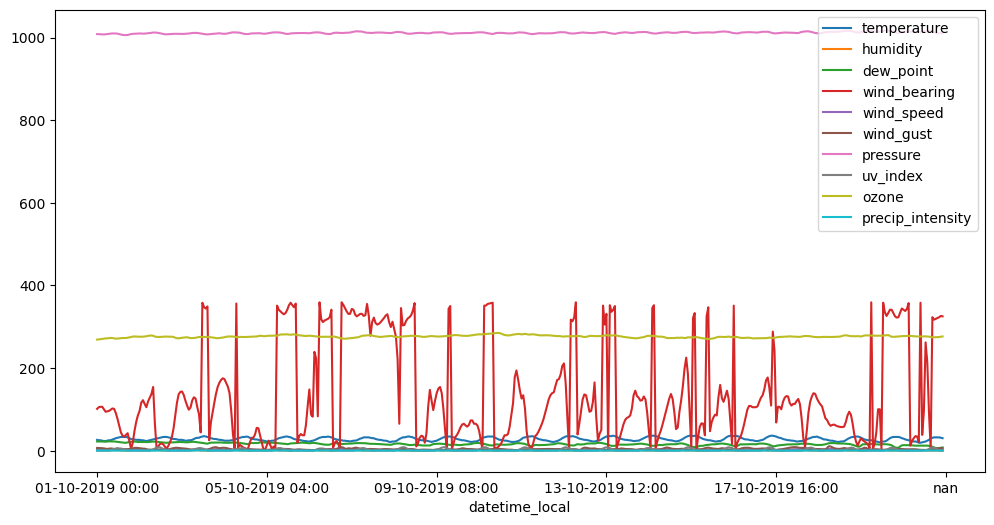

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
len(df)

648

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 648 entries, 01-10-2019 00:00 to nan
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       499 non-null    float64
 1   humidity          499 non-null    float64
 2   dew_point         499 non-null    float64
 3   wind_bearing      499 non-null    float64
 4   wind_speed        499 non-null    float64
 5   wind_gust         499 non-null    float64
 6   pressure          499 non-null    float64
 7   uv_index          499 non-null    float64
 8   ozone             499 non-null    float64
 9   precip_intensity  499 non-null    float64
 10  icon              499 non-null    object 
dtypes: float64(10), object(1)
memory usage: 60.8+ KB


In [ ]:
df['icon'].value_counts()

,count
icon,
clear-night,182
clear-day,159
partly-cloudy-night,64
partly-cloudy-day,64
cloudy,30


# Some necessary preprocessing

In [ ]:
df.dropna(inplace=True)
len(df)

499

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499 entries, 01-10-2019 00:00 to 21-10-2019 18:00
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temperature       499 non-null    float64
 1   humidity          499 non-null    float64
 2   dew_point         499 non-null    float64
 3   wind_bearing      499 non-null    float64
 4   wind_speed        499 non-null    float64
 5   wind_gust         499 non-null    float64
 6   pressure          499 non-null    float64
 7   uv_index          499 non-null    float64
 8   ozone             499 non-null    float64
 9   precip_intensity  499 non-null    float64
 10  icon              499 non-null    object 
dtypes: float64(10), object(1)
memory usage: 46.8+ KB


In [ ]:
scaler = MinMaxScaler()

In [ ]:
df.drop('icon',axis=1,inplace=True)
scaler.fit(df)
scaled_data = scaler.transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [ ]:
scaled_df.head()

,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity
0,0.411765,1.0,0.979530,0.281337,0.692737,0.575258,0.226898,0.0,0.000000,0.0
1,0.352941,1.0,0.982541,0.292479,0.653631,0.560825,0.207685,0.0,0.030675,0.0
2,0.352941,1.0,0.982541,0.295265,0.620112,0.540206,0.176578,0.0,0.067485,0.0
3,0.294118,1.0,0.971102,0.295265,0.567039,0.505155,0.150046,0.0,0.110429,0.0
4,0.235294,1.0,0.950632,0.278552,0.500000,0.459794,0.140897,0.0,0.165644,0.0


# Train & test split

In [ ]:
train_size = int(len(scaled_df) * 0.8)
train = scaled_df.iloc[:train_size]
test = scaled_df.iloc[train_size:]
train.shape, test.shape

# Convert DataFrame to NumPy array
train_array = train.values

# Turning the data into a time series

In [ ]:
# define an input length for 7 days
n_input = 7
generator = TimeseriesGenerator(train_array, train_array, length=n_input, batch_size=1)

In [ ]:
X,y = generator[1]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.35294118 1.         0.98254064 0.29247911 0.65363128 0.56082474
 0.20768527 0.         0.03067485 0.         0.35294118 1.
 0.98254064 0.29526462 0.62011173 0.54020619 0.17657823 0.
 0.06748466 0.         0.29411765 1.         0.97110175 0.29526462
 0.56703911 0.50515464 0.15004575 0.         0.11042945 0.
 0.23529412 1.         0.95063215 0.27855153 0.5        0.45979381
 0.14089661 0.         0.16564417 0.         0.23529412 1.
 0.95243829 0.26183844 0.41620112 0.3742268  0.1884721  0.
 0.18404908 0.         0.29411765 1.         0.97712222 0.26462396
 0.47765363 0.33298969 0.24153705 0.         0.19631902 0.
 0.35294118 1.         0.99939795 0.26740947 0.66480447 0.39278351
 0.27447392 0.         0.23312883 0.        ]
Predict this y: 
 [[0.35294118 1.         1.         0.27576602 0.79329609 0.44329897
  0.32570906 0.125      0.25766871 0.        ]]


# Defining a deep learning GRU model

In [ ]:
# define model
n_features = 10

model = Sequential()

model.add(GRU(200, activation='tanh', input_shape=(n_input, n_features), return_sequences=True))
model.add(GRU(200, activation='tanh', return_sequences=True))
model.add(GRU(200, activation='relu'))
model.add(Dense(10))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 7, 200)              │         127,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 7, 200)              │         241,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 200)                 │         241,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 611,610 (2.33 MB)

 Trainable params: 611,610 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

# Model training

In [ ]:
# training the model
model.fit(generator,epochs=150)

Epoch 1/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0198
Epoch 2/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0174
Epoch 3/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0185
Epoch 4/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.0136
Epoch 5/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - loss: 0.0146
Epoch 6/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 0.0129
Epoch 7/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - loss: 0.0138
Epoch 8/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0125
Epoch 9/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0123
Epoch 10/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0120
Epoch 11/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0110
Epoch 12/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - loss: 0.0124
Epoch 13/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - loss: 0.0091
Epoch 14/150
392/392 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 0.0101
Epoch 15/150
39

# Testing the model, visuaizing the loss

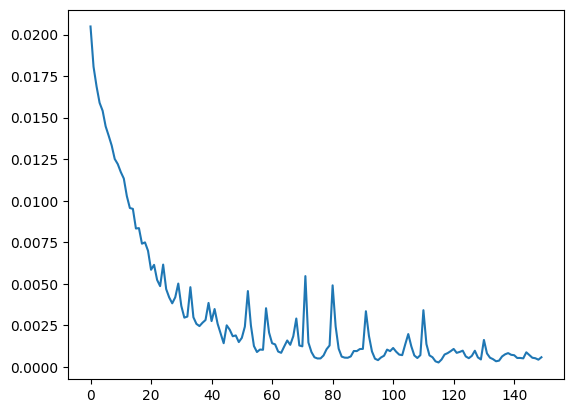

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
test_predictions = []

first_eval_batch = train_array[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    print(current_pred)
    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_pred = current_pred.reshape((1, 1, n_features))
    current_batch = np.append(current_batch[:,1:,:], current_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[ 0.97401166 -0.02556151  0.30317947  0.9011766   0.05580837  0.08085404
  0.4286585   0.71087116  0.29605854  0.36402825]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[ 0.98366404 -0.02878684  0.26656058  0.29841965  0.21737155  0.10771167
  0.4426849   0.44264552  0.32271543  0.16001698]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[ 0.9161749  -0.1352148   0.2559487   0.162291    0.33451363  0.06144044
  0.401183    0.08459557  0.33652768  0.06180682]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[ 0.8260217  -0.08016029  0.32142395  0.1995311   0.32336578  0.08195987
  0.43057036  0.01311244  0.35696593  0.00847693]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[ 0.68373585 -0.01363868  0.35026798  0.15867813  0.33516932  0.1776953
  0.5038196  -0.00920356  0.32166085  0.00137494]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
[ 0.6152878   0.01516275  0.3835322   0.22657363  0.40402144  0.30928585
  0.55080247 -0.02861699  0.28785512 -0.01226381]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/st

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions

array([[ 3.55581982e+01, -2.55615115e-02,  1.07758110e+01,
         3.23522389e+02,  7.99793948e-01,  1.62428422e+00,
         1.01065524e+03,  5.68696928e+00,  2.73425754e+02,
         1.52891863e-01],
       [ 3.57222886e+01, -2.87868381e-02,  1.01675713e+01,
         1.07132656e+02,  1.37819016e+00,  1.88480323e+00,
         1.01080855e+03,  3.54116416e+00,  2.73860262e+02,
         6.72071332e-02],
       [ 3.45749731e+01, -1.35214806e-01,  9.99130778e+00,
         5.82624709e+01,  1.79755881e+00,  1.43597225e+00,
         1.01035493e+03,  6.76764548e-01,  2.74085401e+02,
         2.59588645e-02],
       [ 3.30423684e+01, -8.01602900e-02,  1.10788518e+01,
         7.16316625e+01,  1.75764948e+00,  1.63501077e+00,
         1.01067613e+03,  1.04899526e-01,  2.74418545e+02,
         3.56031010e-03],
       [ 3.06235094e+01, -1.36386752e-02,  1.15579511e+01,
         5.69654484e+01,  1.79990615e+00,  2.56364445e+00,
         1.01147675e+03, -7.36284852e-02,  2.73843072e+02,
         5.

In [ ]:
test = pd.DataFrame(scaler.inverse_transform(test.values), columns=test.columns)

In [ ]:
# Iterate over the columns of the predicted features
for i, col in enumerate(test.columns):
    # Create a column name (e.g., 'Predicted Temperature', 'Predicted Humidity', etc.)
    new_col_name = f'Predicted {col}'
    # Assign the corresponding column from true_predictions to the DataFrame
    test[new_col_name] = true_predictions[:, i]

In [ ]:
test.head()

,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,ozone,precip_intensity,Predicted temperature,Predicted humidity,Predicted dew_point,Predicted wind_bearing,Predicted wind_speed,Predicted wind_gust,Predicted pressure,Predicted uv_index,Predicted ozone,Predicted precip_intensity
0,35.0,0.0,10.36,242.0,0.65,1.47,1010.18,3.0,273.0,0.16,35.558198,-0.025562,10.775811,323.522389,0.799794,1.624284,1010.655237,5.686969,273.425754,0.152892
1,34.0,0.0,11.35,68.0,1.19,1.60,1010.23,1.0,273.9,0.07,35.722289,-0.028787,10.167571,107.132656,1.378190,1.884803,1010.808546,3.541164,273.860262,0.067207
2,32.0,0.0,12.46,106.0,1.94,2.20,1010.66,0.0,274.9,0.00,34.574973,-0.135215,9.991308,58.262471,1.797559,1.435972,1010.354930,0.676765,274.085401,0.025959
3,31.0,0.0,12.99,106.0,2.20,2.62,1010.98,0.0,275.2,0.00,33.042368,-0.080160,11.078852,71.631662,1.757649,1.635011,1010.676134,0.104900,274.418545,0.003560
4,30.0,0.0,13.26,100.0,2.27,3.06,1011.54,0.0,275.2,0.00,30.623509,-0.013639,11.557951,56.965448,1.799906,2.563644,1011.476748,-0.073628,273.843072,0.000577


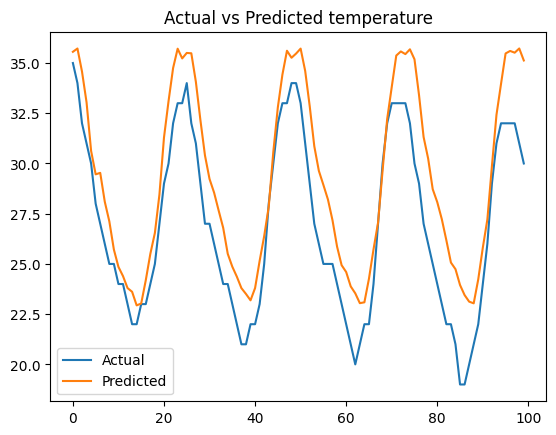

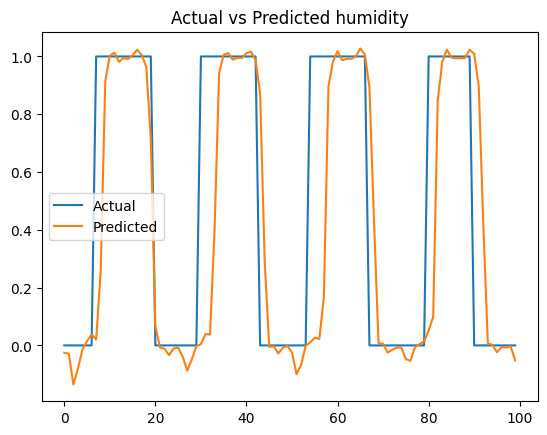

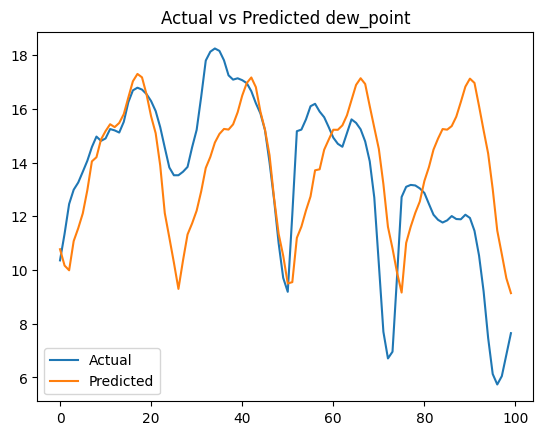

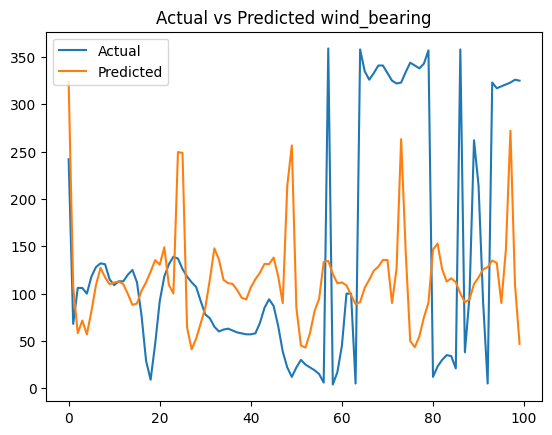

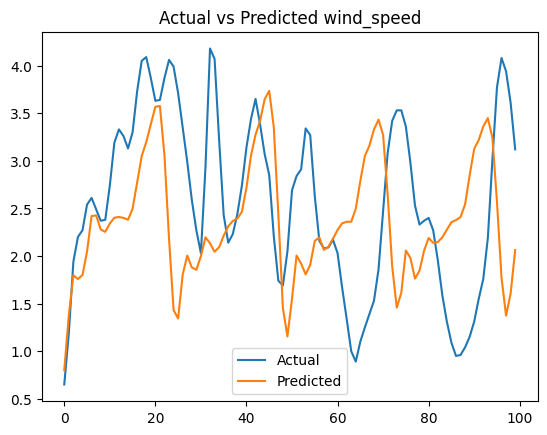

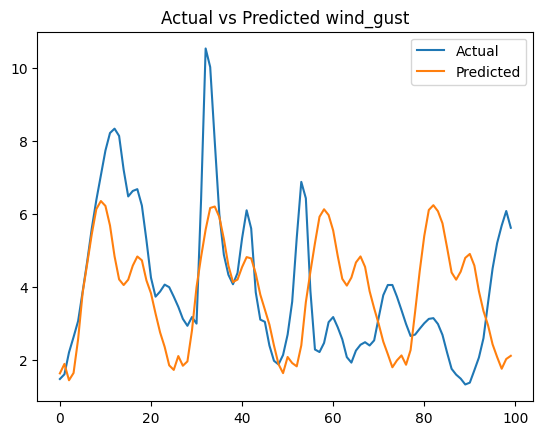

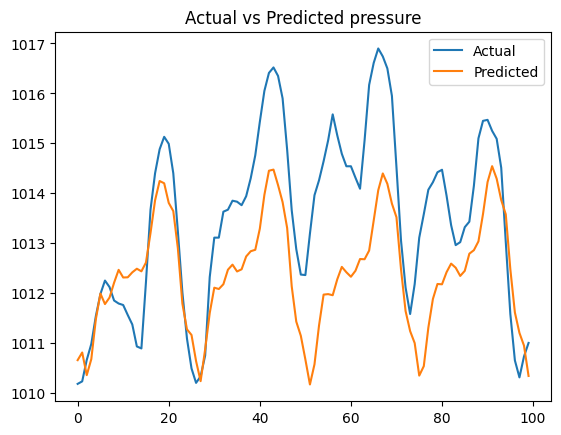

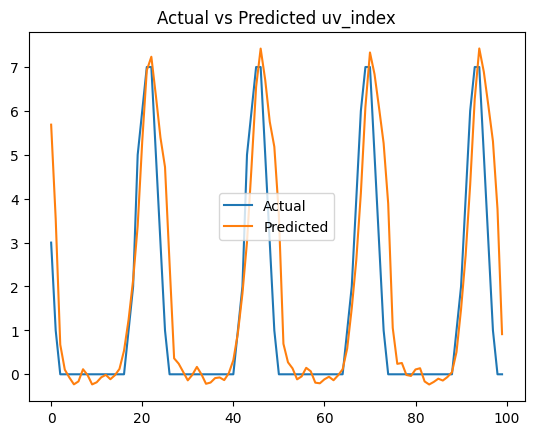

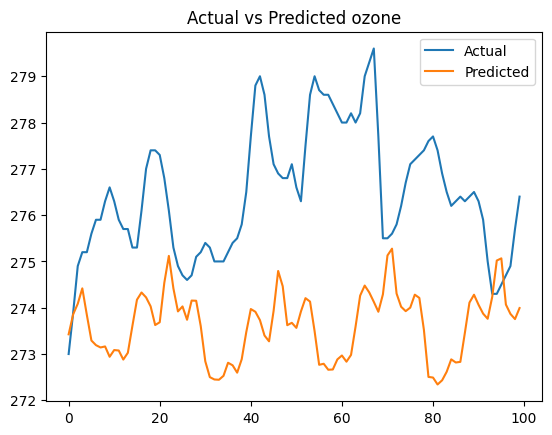

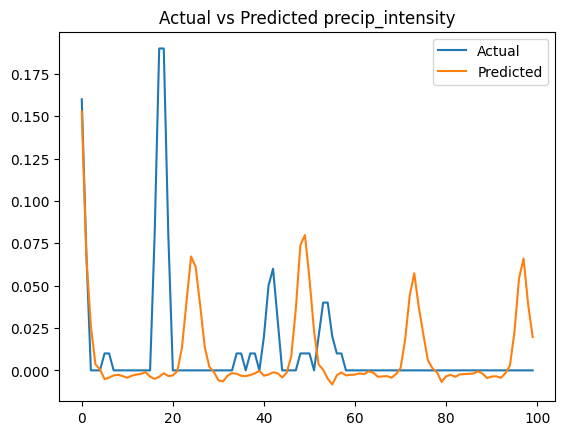

In [ ]:
# Iterate through the features (first 10 columns)
for i in range(10):
    # Create a figure and axes for the plot
    fig, ax = plt.subplots()

    # Plot the actual values
    ax.plot(test.index, test.iloc[:, i], label='Actual')

    # Plot the predicted values
    ax.plot(test.index, test.iloc[:, i + 10], label='Predicted')

    # Set the title of the plot (using the column name)
    ax.set_title(f'Actual vs Predicted {test.columns[i]}')

    # Add a legend to the plot
    ax.legend()

    # Display the plot
    plt.show()

In [ ]:
for i in range(10):
    # Calculate RMSE for the current feature
    rmse = sqrt(mean_squared_error(test.iloc[:, i], test.iloc[:, i + 10]))

    # Print the RMSE value
    print(f'RMSE for {test.columns[i]}: {rmse}')

RMSE for temperature: 2.6633433064891165
RMSE for humidity: 0.37464629981768144
RMSE for dew_point: 2.780503530755041
RMSE for wind_bearing: 129.6789763771656
RMSE for wind_speed: 1.1240390121355084
RMSE for wind_gust: 2.125838695766239
RMSE for pressure: 1.6444407300281056
RMSE for uv_index: 1.4174105638635008
RMSE for ozone: 3.266567958483944
RMSE for precip_intensity: 0.03814296401623344
